<a href="https://colab.research.google.com/github/Jerryson520/Optiver-Trading-at-the-Close/blob/main/Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

In [6]:
# # !pip install lightgbm
# !pip install scikit-learn==1.5.2

In [7]:
# !pip install numpy==1.26.4

In [8]:
work_dir = '/content/drive/MyDrive/Optiver-trading-at-close'

# Standard Libraries
import os
import collections
import random
import sys

# Data Science Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numba
from tqdm import tqdm

# # Configure Visualization
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# from utils import inspect_columns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn
import lightgbm
import xgboost as xgb
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# import cupy as cp
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)


# import warnings
# warnings.filterwarnings('ignore')

In [9]:
# utils.py
def inspect_columns(df):
    """
    Inspect various characteristics of columns in a DataFrame, providing
    details on column lengths, uniqueness, cardinality, null values, sample rows,
    and data types.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame to inspect.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame where each row represents a column from the input DataFrame,
        with the following columns:
        - 'len': The total number of rows in the DataFrame.
        - 'unique': A boolean indicating if all values in the column are unique.
        - 'cardinality': The number of unique values in each column.
        - 'null_cnt': The count of null (NaN) values in each column.
        - 'null_pct': The percentage of null (NaN) values in each column.
        - '1st_row': The value in the first row of each column.
        - 'random_row': A random value from each column.
        - 'last_row': The value in the last row of each column.
        - 'dtype': The data type of each column.

    Example:
    -------
    >>> df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, None]})
    >>> inspect_columns(df)
           len  unique  cardinality  null_cnt    null_pct 1st_row  random_row  last_row dtype
    A       3    False          3       0          0.0      1         2          3       int64
    B       3    False          2       1         33.33     4         5        None       float64
    """
    result = pd.DataFrame(
        {
            "len": len(df),
            "unique": df.nunique() == len(df),
            "cardinality": df.nunique(),
            "null_cnt": df.isna().sum(),
            "null_pct": df.isnull().sum() / len(df) * 100,
            "1st_row": df.iloc[0],
            "random_row": df.iloc[np.random.randint(low=0, high=len(df))],
            "last_row": df.iloc[-1],
            "dtype": df.dtypes,
        }
    )

    return result

### Config

In [10]:
GENERATE_FEATURE = True
USE_PCA = False
XGBOOST = True
XGBOOST_FEVAL = True
XGBOOST_FSELECTION = False

## Load Data

In [11]:
input_path = work_dir + '/train.csv'
df = pd.read_csv(input_path)
df.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


## Missing value imputation

In [12]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the given DataFrame by performing the following steps:

    1. Drops rows where 'target' or 'wap' are missing.
    2. Fills missing 'far_price' and 'near_price' values with 0 if 'seconds_in_bucket' is <= 300.
    3. Fills all remaining missing values with 0 and resets the index.

    Args:
        df (pd.DataFrame): Input DataFrame containing financial data.

    Returns:
        pd.DataFrame: Cleaned DataFrame with missing values handled.
    """
    # Step 1 & 2: Drop rows where 'target' or 'wap' are missing
    df_cleaned = df.dropna(subset=['target', 'wap'])

    # Step 3: Fill missing 'far_price' and 'near_price' with 0 when 'seconds_in_bucket' <= 300
    mask = df_cleaned['seconds_in_bucket'] <= 300
    df_cleaned.loc[mask & df_cleaned['far_price'].isnull(), 'far_price'] = 0
    df_cleaned.loc[mask & df_cleaned['near_price'].isnull(), 'near_price'] = 0

    # Step 4: Fill remaining missing values with 0 and reset index
    df_cleaned = df_cleaned.fillna(0).reset_index(drop=True)

    return df_cleaned

df_cleaned = clean_dataframe(df)

In [13]:
inspect_columns(df_cleaned)

,len,unique,cardinality,null_cnt,null_pct,1st_row,random_row,last_row,dtype
stock_id,5237760,False,200,0,0.0,0,136,199,int64
date_id,5237760,False,481,0,0.0,0,92,480,int64
seconds_in_bucket,5237760,False,55,0,0.0,0,540,540,int64
imbalance_size,5237760,False,2971863,0,0.0,3180602.69,396055.78,1884285.71,float64
imbalance_buy_sell_flag,5237760,False,3,0,0.0,1,-1,-1,int64
reference_price,5237760,False,28741,0,0.0,0.999812,0.995963,1.002129,float64
matched_size,5237760,False,2948862,0,0.0,13380276.64,9430865.91,24073677.32,float64
far_price,5237760,False,95740,0,0.0,0.0,0.993862,1.000859,float64
near_price,5237760,False,84626,0,0.0,0.0,0.995162,1.001494,float64
bid_price,5237760,False,28313,0,0.0,0.999812,0.995862,1.002129,float64


In [14]:
(df_cleaned.groupby(['date_id', 'stock_id'])['seconds_in_bucket'].size() != 55).sum()

0

In [15]:
df_sampling = df_cleaned.query('date_id <= 480 and date_id >= 450').reset_index(drop=True)

In [16]:
len(df_sampling)

341000

In [17]:
(df_sampling.groupby(['date_id', 'stock_id'])['seconds_in_bucket'].size() != 55).sum()

0

## Feature Engineering

In [18]:
df_sampling

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,450,0,6142558.25,1,0.999912,13264336.31,0.000000,0.000000,0.999912,7956.06,1.000079,7179.60,1.000000,-1.109838,24750,450_0_0
1,1,450,0,1310860.38,1,1.000074,1589558.48,0.000000,0.000000,0.999976,6732.66,1.000074,20404.00,1.000000,18.559694,24750,450_0_1
2,2,450,0,5410435.23,1,1.000712,4697298.14,0.000000,0.000000,0.999170,26308.73,1.001458,46296.70,1.000000,4.609823,24750,450_0_2
3,3,450,0,11951807.40,1,0.999705,58138966.48,0.000000,0.000000,0.999351,80545.30,1.000008,990.15,1.000000,-0.630021,24750,450_0_3
4,4,450,0,7575764.95,1,0.999792,17294499.89,0.000000,0.000000,0.999792,1992.54,1.000454,4350.24,1.000000,-4.580021,24750,450_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
340996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
340997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
340998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


After exploration, we find that nan appears in the data is because:
1. reference_price = bid_price = wap
2. imbalance_buy_sell_flag cannot calculate return
3. fill with bfill
4. replace inf or -inf with 0.

In [19]:
@numba.jit(nopython=True)
def double_imbalance(array1, array2):
    """
    Computes the double imbalance ratio for order book sizes.

    Args:
        array1 (np.ndarray): First array of order sizes.
        array2 (np.ndarray): Second array of order sizes.

    Returns:
        np.ndarray: Computed imbalance ratios.
    """
    n = len(array1)
    res = np.zeros(n, dtype=np.float32)

    for i in range(n):
        denom = array1[i] + array2[i]
        if denom != 0:
            res[i] = (array1[i] - array2[i]) / denom

    return res


@numba.jit(nopython=True)
def triplet_imbalance(array1, array2, array3):
    """
    Computes the triplet imbalance ratio.

    Args:
        array1 (np.ndarray): First array.
        array2 (np.ndarray): Second array.
        array3 (np.ndarray): Third array.

    Returns:
        np.ndarray: Computed triplet imbalance ratios.
    """
    n = len(array1)
    res = np.zeros(n, dtype=np.float32)

    for i in range(n):
        max_ = max(array1[i], array2[i], array3[i])
        min_ = min(array1[i], array2[i], array3[i])
        mid_ = array1[i] + array2[i] + array3[i] - max_ - min_

        if mid_ != min_:
            res[i] = (max_ - mid_) / (mid_ - min_)

    return res


@numba.jit(nopython=True)
def cross_feature(array1, array2):
    """
    Computes the element-wise product of two arrays.

    Args:
        array1 (np.ndarray): First array.
        array2 (np.ndarray): Second array.

    Returns:
        np.ndarray: Element-wise product of both arrays.
    """
    return array1 * array2


def imbalance_features(df):
    """
    Generates imbalance-related features for a given DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame with order book data.

    Returns:
        pd.DataFrame: DataFrame with added imbalance features.
    """
    new_feature_dict = {}

    # Order size imbalance
    sizes = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
    for i in range(len(sizes)):
        for j in range(i + 1, len(sizes)):
            array1, array2 = df[sizes[i]].to_numpy(), df[sizes[j]].to_numpy()
            new_feature_dict[f'{sizes[i]}_{sizes[j]}_imb'] = double_imbalance(array1, array2)

            for z in range(j + 1, len(sizes)):
                array3 = df[sizes[z]].to_numpy()
                new_feature_dict[f'{sizes[i]}_{sizes[j]}_{sizes[z]}_imb'] = triplet_imbalance(array1, array2, array3)

    # Price imbalance
    prices = ['reference_price', 'ask_price', 'bid_price', 'wap']
    for i in range(len(prices)):
        for j in range(i + 1, len(prices)):
            array1, array2 = df[prices[i]].to_numpy(), df[prices[j]].to_numpy()
            new_feature_dict[f'{prices[i]}_{prices[j]}_imb'] = double_imbalance(array1, array2)

            for z in range(j + 1, len(prices)):
                array3 = df[prices[z]].to_numpy()
                new_feature_dict[f'{prices[i]}_{prices[j]}_{prices[z]}_imb'] = triplet_imbalance(array1, array2, array3)

    # Cross features
    final = ['imbalance_buy_sell_flag'] + sizes + prices
    for i in range(len(final)):
        for j in range(len(final)):
            array1, array2 = df[final[i]].to_numpy(), df[final[j]].to_numpy()
            new_feature_dict[f'{final[i]}_{final[j]}_cross_imb'] = cross_feature(array1, array2)

    return pd.concat([df, pd.DataFrame(new_feature_dict)], axis=1)


def statistical_features(df):
    """
    Generates statistical features for a given DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with added statistical features.
    """
    new_feature_dict = {
        'volume': df.eval('ask_size + bid_price'),
        'reference_volume': df.eval('imbalance_size + matched_size'),
        'mid_size': df.eval('(ask_size + bid_size) / 2'),
        'mid_price': df.eval('(ask_price + bid_price) / 2'),
        'spread': df.eval('ask_price - bid_price'),
    }

    # Statistical Aggregation
    prices = ['reference_price', 'ask_price', 'bid_price', 'wap']
    for func in ["mean", "std", "skew", "kurt"]:
        new_feature_dict[f"all_prices_{func}"] = df[prices].agg(func, axis=1)

    return pd.concat([df, pd.DataFrame(new_feature_dict)], axis=1)


def temporal_features(df):
    """
    Generates temporal-based features (lags, moving averages, and differences).

    Args:
        df (pd.DataFrame): Input DataFrame with time-series stock data.

    Returns:
        pd.DataFrame: DataFrame with added temporal features.
    """
    df = df.copy()
    grouped = df.groupby(['stock_id', 'date_id'])

    # Lag Features
    lag_feat = ['bid_size', 'ask_size', 'matched_size', 'imbalance_size', 'reference_price']
    for window in tqdm(range(1, 11), desc='Generating Lag Features'):
        new_lag_feat = [f"{col}_lag_{window}" for col in lag_feat]
        df[new_lag_feat] = grouped[lag_feat].shift(window).bfill()

    # Difference Features
    diff_feat = ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'matched_size', 'imbalance_size', 'spread']
    for window in tqdm(range(1, 11), desc='Generating Difference Features'):
        new_diff_feat = [f"{col}_diff_{window}" for col in diff_feat]
        df[new_diff_feat] = grouped[diff_feat].diff(window).fillna(0)

    # Moving Averages
    ma_feat = diff_feat + ['reference_price']
    for window in tqdm(range(1, 11), desc='Generating Moving Average Features'):
        new_ma_feat = [f"{col}_ma_{window}" for col in ma_feat]
        df[new_ma_feat] = grouped[ma_feat].rolling(window=window, min_periods=1).mean().reset_index(drop=True)

    # Exponential Moving Averages
    ema_feat = ma_feat
    for alpha in tqdm(np.linspace(0.5, 1, 11), desc='Generating EMA Features'):
        new_ema_feat = [f"{col}_ema_{alpha:.1f}" for col in ema_feat]
        df[new_ema_feat] = grouped[ema_feat].ewm(alpha=alpha, adjust=False).mean().reset_index(drop=True)

    return df

In [20]:
def generate_new_features(df):
  df_new = imbalance_features(df)
  df_new = statistical_features(df_new)
  df_new = temporal_features(df_new)
  return df_new

In [21]:
generate_new_features(df_sampling)

Generating Difference Features:  50%|█████     | 5/10 [00:00<00:00, 46.94it/s]<ipython-input-19-9290fe4a7d7c>:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_diff_feat] = grouped[diff_feat].diff(window).fillna(0)
<ipython-input-19-9290fe4a7d7c>:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_diff_feat] = grouped[diff_feat].diff(window).fillna(0)
<ipython-input-19-9290fe4a7d7c>:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,spread_ema_0.9,reference_price_ema_0.9,ask_price_ema_1.0,bid_price_ema_1.0,ask_size_ema_1.0,bid_size_ema_1.0,matched_size_ema_1.0,imbalance_size_ema_1.0,spread_ema_1.0,reference_price_ema_1.0
0,0,450,0,6142558.25,1,0.999912,13264336.31,0.000000,0.000000,0.999912,...,0.000167,0.999912,1.000079,0.999912,7179.60,7956.06,13264336.31,6142558.25,0.000167,0.999912
1,1,450,0,1310860.38,1,1.000074,1589558.48,0.000000,0.000000,0.999976,...,0.000167,1.000071,1.000079,0.999912,12624.13,43608.78,13288804.84,6118089.72,0.000167,1.000079
2,2,450,0,5410435.23,1,1.000712,4697298.14,0.000000,0.000000,0.999170,...,0.000167,1.000237,1.000246,1.000079,8497.28,35898.00,13288804.84,6978257.27,0.000167,1.000246
3,3,450,0,11951807.40,1,0.999705,58138966.48,0.000000,0.000000,0.999351,...,0.000167,1.000087,1.000079,0.999912,538.47,30268.92,13501663.11,6765399.00,0.000167,1.000079
4,4,450,0,7575764.95,1,0.999792,17294499.89,0.000000,0.000000,0.999792,...,0.000167,1.000238,1.000246,1.000079,359.04,36496.30,13995161.65,6271900.46,0.000167,1.000246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,0.000318,1.002716,1.003082,1.002764,425296.17,122246.18,23969215.23,2661783.46,0.000318,1.002764
340996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,0.000318,1.002762,1.003082,1.002764,347268.87,677012.04,23972081.09,2658917.61,0.000318,1.002764
340997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.000317,1.001859,1.002129,1.001812,194630.52,225361.65,23978379.68,1352558.88,0.000317,1.001812
340998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.000317,1.001814,1.002129,1.001812,214513.32,285559.05,23978379.68,1352558.88,0.000317,1.001812


In [22]:
# Toggle feature generation
GENERATE_FEATURE = False

if GENERATE_FEATURE:
    print("Generating features...")

    # Apply imbalance features
    df_sampling_w_feat = imbalance_features(df_sampling)
    print(f"Feature set size after imbalance features: {df_sampling_w_feat.shape}")

    # Apply statistical features
    df_sampling_w_feat = statistical_features(df_sampling_w_feat)
    print(f"Feature set size after statistical features: {df_sampling_w_feat.shape}")

    # Apply temporal features
    df_sampling_w_feat = temporal_features(df_sampling_w_feat)
    print(f"Feature set size after temporal features: {df_sampling_w_feat.shape}")

else:
    print("Loading precomputed feature dataset...")
    df_sampling_w_feat = pd.read_parquet('/content/drive/MyDrive/Optiver-trading-at-close/df_sampling_w_feat.parquet')

print(f"Final DataFrame shape: {df_sampling_w_feat.shape}")

Loading precomputed feature dataset...
Final DataFrame shape: (341000, 182)


In [23]:
# df_sampling_w_feat.to_parquet('/content/drive/MyDrive/Optiver-trading-at-close/df_sampling_w_feat.parquet')

## Feature selection

In [24]:
def plot_pca_explained_variance(pca, threshold=0.99):
    """
    Plots the cumulative explained variance ratio from a fitted PCA model
    and identifies the number of components required to reach the given threshold.

    Args:
        pca (PCA object): A fitted PCA model from sklearn.
        threshold (float, optional): The cumulative variance threshold for selecting components (default=0.99).

    Returns:
        int: The number of principal components needed to reach the threshold.
    """
    # Ensure the PCA object is fitted
    if not hasattr(pca, "explained_variance_ratio_"):
        raise ValueError("PCA object must be fitted before calling this function.")

    # Compute the explained variance ratio
    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)

    # Identify the first component count that meets or exceeds the threshold
    num_components = np.argmax(cumulative_variance >= threshold) + 1 if np.any(cumulative_variance >= threshold) else len(cumulative_variance)
    threshold_value = cumulative_variance[num_components - 1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance, ax=ax, label="Cumulative Explained Variance")

    # Highlight the threshold point
    sns.scatterplot(x=[num_components], y=[threshold_value], color='red', ax=ax, s=100, label=f'Threshold ({threshold_value:.2%})')
    ax.axvline(num_components, linestyle="--", color="red", alpha=0.6)  # Vertical threshold line

    # Annotate the threshold point
    ax.text(num_components + 0.5, threshold_value - 0.02, f'({num_components}, {threshold_value:.2%})', color='red', fontsize=12)

    # Titles and labels
    ax.set_title("Cumulative Explained Variance Ratio", fontsize=14)
    ax.set_xlabel("Number of Principal Components", fontsize=12)
    ax.set_ylabel("Cumulative Explained Variance", fontsize=12)
    ax.legend()

    plt.show()

    return num_components

In [25]:
def plot_pca_explained_variance(pca, threshold=0.99):
    """
    Plots the cumulative explained variance ratio from a fitted PCA model.

    Args:
        pca (PCA object): A fitted PCA model from sklearn.
        threshold (float, optional): The cumulative variance threshold for selecting components (default=0.99).

    Returns:
        int: The number of principal components needed to reach the threshold.
    """
    # Ensure the PCA object is fitted
    if not hasattr(pca, "explained_variance_ratio_"):
        raise ValueError("PCA object must be fitted before calling this function.")

    # Compute the explained variance ratio
    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)

    # Identify the first component count that meets or exceeds the threshold
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    threshold_value = cumulative_variance[num_components - 1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance, ax=ax, label="Cumulative Explained Variance")

    # Highlight the threshold point
    sns.scatterplot(x=[num_components], y=[threshold_value], color='red', ax=ax, s=100, label=f'Threshold ({threshold_value:.2%})')
    ax.axvline(num_components, linestyle="--", color="red", alpha=0.6)  # Vertical threshold line

    # Annotate the threshold point
    ax.text(num_components + 0.5, threshold_value - 0.02, f'({num_components}, {threshold_value:.2%})', color='red', fontsize=12)

    # Titles and labels
    ax.set_title("Cumulative Explained Variance Ratio", fontsize=14)
    ax.set_xlabel("Number of Principal Components", fontsize=12)
    ax.set_ylabel("Cumulative Explained Variance", fontsize=12)
    ax.legend()

    plt.show()

    return num_components

Applying StandardScaler and PCA...


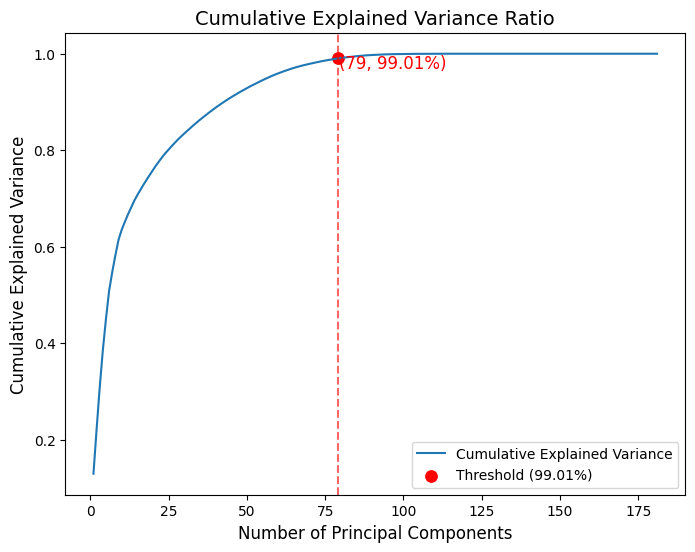

Optimal number of components to retain 79 variance: 79


In [64]:
USE_PCA = True  # Toggle PCA usage

if USE_PCA:
    print("Applying StandardScaler and PCA...")

    # Initialize StandardScaler and PCA
    ss = StandardScaler()
    pca = PCA()

    # Standardize data (excluding target)
    features = df_sampling_w_feat.drop(columns=['target'], errors='ignore')
    standardized_features = ss.fit_transform(features)

    # Fit PCA on standardized data
    pca.fit(standardized_features)

    # Plot PCA explained variance and get the optimal number of components
    optimal_components = plot_pca_explained_variance(pca, threshold=0.99)
    print(f"Optimal number of components to retain {optimal_components} variance: {optimal_components}")

In [74]:
def draw_pca_plot(pca, features):
  new_feat = pca.fit_transform(features)
  PC1, PC2 = new_feat[:,0], new_feat[:,1]
  ratio1, ratio2 = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]

  fig, ax = plt.subplots(1,1)
  ax.scatter(PC1, PC2)
  ax.set_xlabel(f'PC1 ({ratio1*100:.2f}%)')
  ax.set_ylabel(f'PC2 ({ratio2*100:.2f}%)')
  ax.set_title(f'PCA analysis Graph')

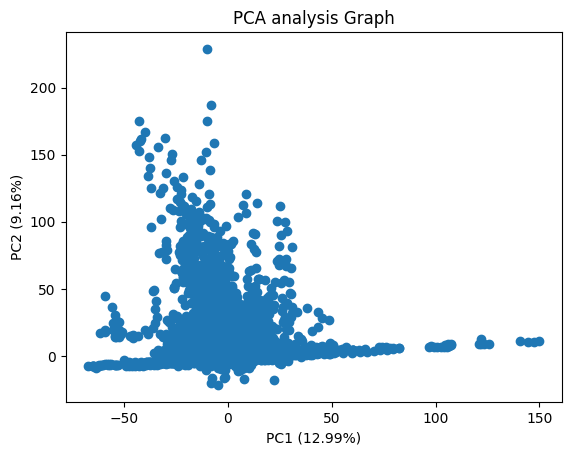

In [75]:
draw_pca_plot(pca, standardized_features)

## Data Sampling

In [58]:
# Define the start date for sampling
START_DATE = 450

# Ensure df_sampling_w_feat contains the necessary 'date_id' column
if 'date_id' not in df_sampling_w_feat.columns:
    raise ValueError("Column 'date_id' is missing from the dataset.")

# Define train-test split based on time
TRAIN_WEEKS = 3
TEST_WEEKS = 1
TRAIN_END_DATE = START_DATE + (TRAIN_WEEKS * 7)

# Train and test split
df_sampling_dev = df_sampling_w_feat.query(f'date_id <= {TRAIN_END_DATE}')
df_sampling_test = df_sampling_w_feat.query(f'date_id > {TRAIN_END_DATE}')

# Generate group labels (weekly bins for training data)
group_label = df_sampling_dev['date_id'].apply(lambda x: (x - START_DATE) // 7)

# Extract features and target variables
drop_columns = ['target', 'row_id']
X_dev, y_dev = df_sampling_dev.drop(columns=drop_columns, errors='ignore'), df_sampling_dev['target']
X_test, y_test = df_sampling_test.drop(columns=drop_columns, errors='ignore'), df_sampling_test['target']

# Validate dimensions
print(f"Training set: {X_dev.shape}, Target: {y_dev.shape}")
print(f"Testing set: {X_test.shape}, Target: {y_test.shape}")

# Initialize GroupTimeSeriesSplit
cv_args = {"test_size": 1, "train_size": 1}
cv = GroupTimeSeriesSplit(**cv_args).split(X_dev, y_dev, groups=group_label)

# Debug: Print group assignments for validation
print(f"Unique group labels in training data: {group_label.unique()}")

Training set: (242000, 180), Target: (242000,)
Testing set: (99000, 180), Target: (99000,)
Unique group labels in training data: [0 1 2 3]


## XGBoost

In [66]:
# Define the pipeline
if XGBOOST:
  xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
  )

  xgb_pipeline.fit(X_dev, y_dev)
  print(mean_absolute_error(y_test, xgb_pipeline.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:54:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:54:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


5.705570605310348


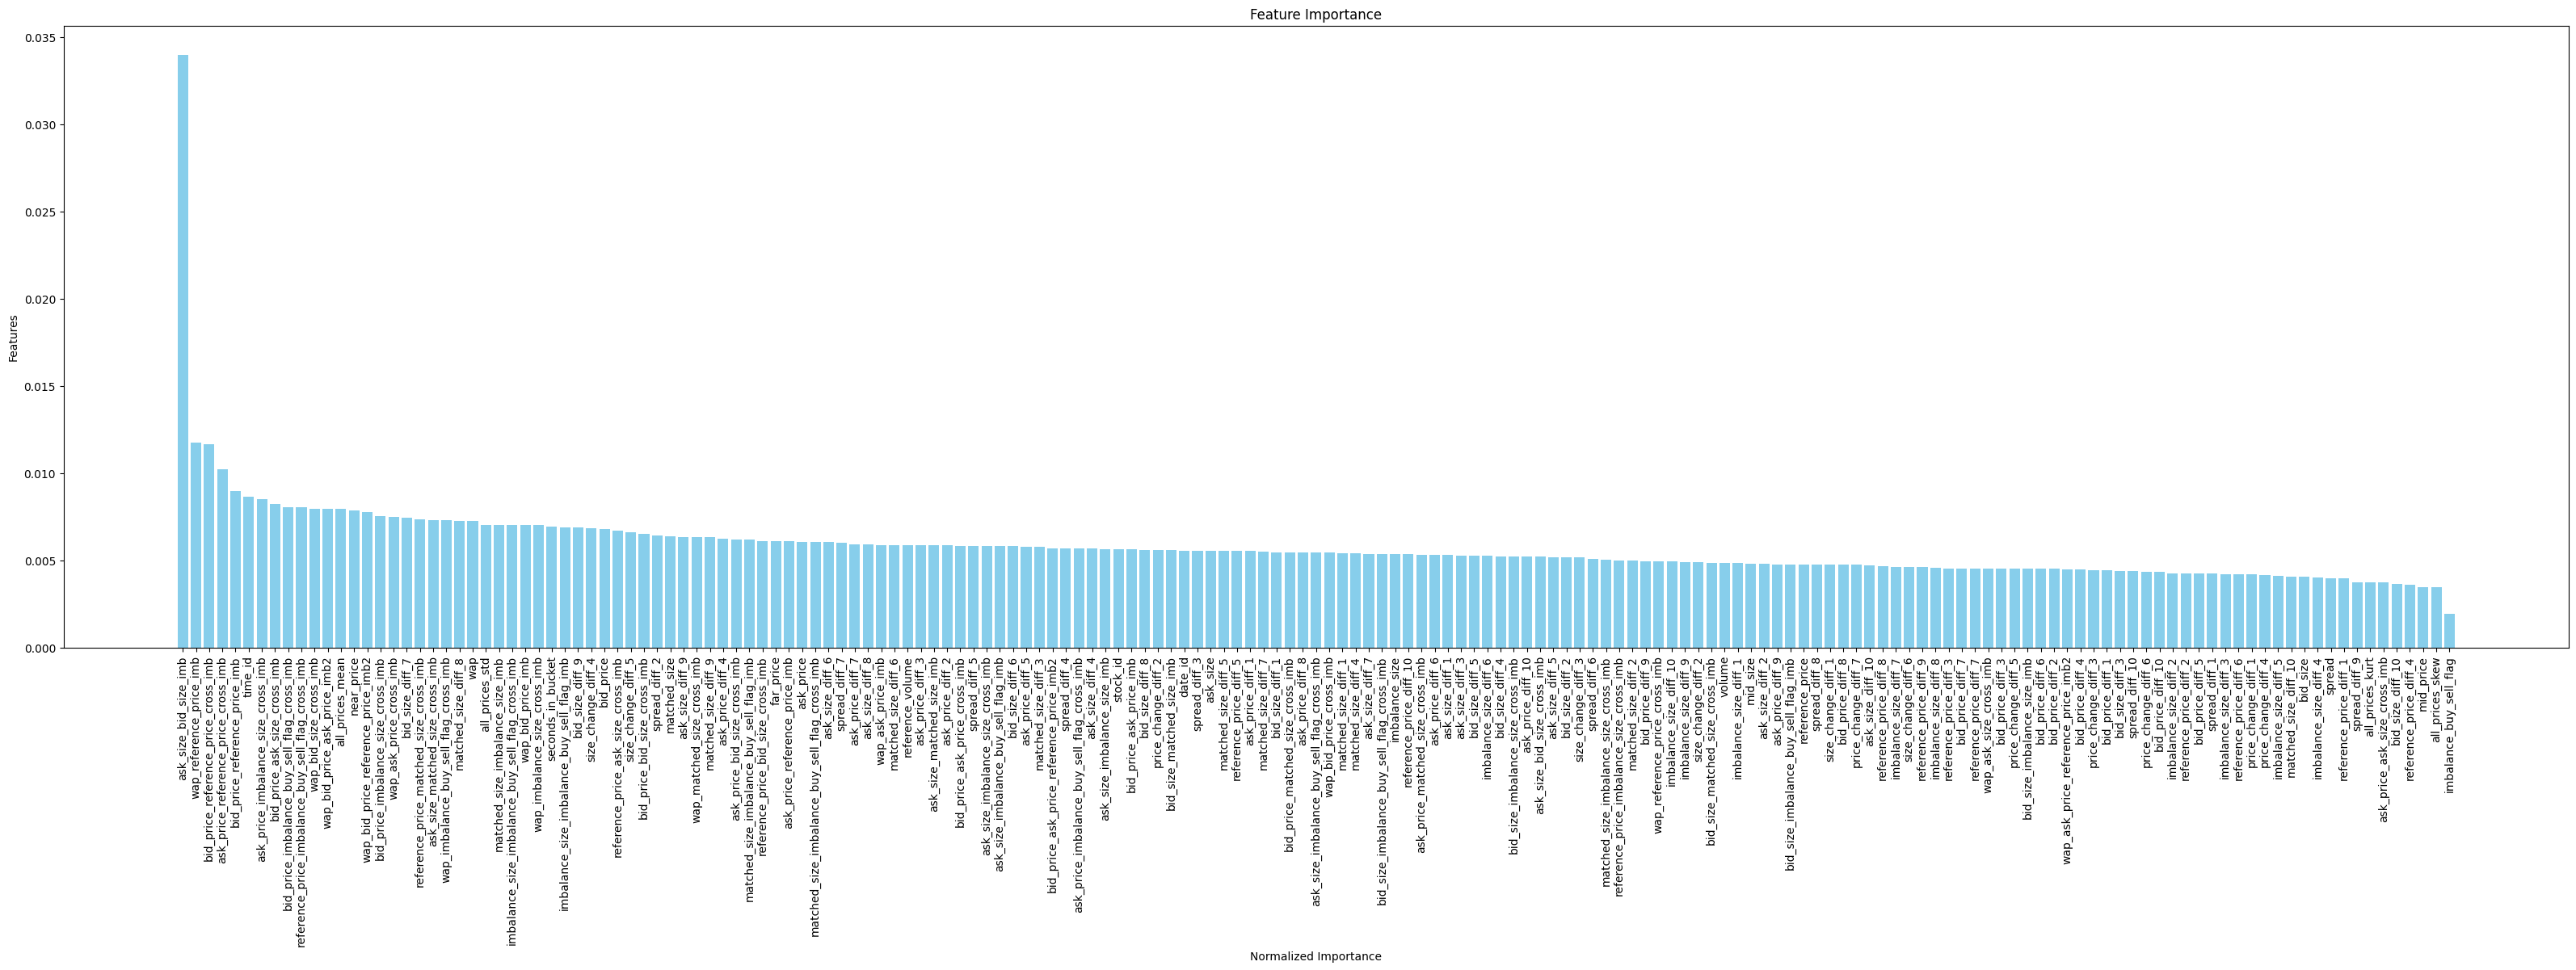

In [68]:
if XGBOOST_FEVAL:
  fig, ax = plt.subplots(1,1,figsize=(40, 10))
  # xgb_clf = xgb_pipeline.named_steps['xgbregressor']
  # xgb_clf.get_booster().feature_names = list(X_dev.columns)
  # xgb.plot_importance(xgb_clf.get_booster(), importance_type='gain', ax=ax, values_format='{v:.2f}')
  booster = xgb_pipeline.named_steps['xgbregressor'].get_booster()
  importance_dict = booster.get_score(importance_type='gain')  # Replace 'gain' with 'weight' or 'cover'
  importance_dict = {name: item[1] for name, item in zip(X_dev.columns, importance_dict.items())}
  # Using get_score
  importance_values = list(importance_dict.values())
  normalized_importance_dict = {k: v / sum(importance_values) for k, v in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)}
  # Create horizontal bar plot
  ax.bar(list(normalized_importance_dict.keys()), list(normalized_importance_dict.values()), color='skyblue')
  ax.set_xlabel('Normalized Importance')
  plt.xticks(rotation=90)
  ax.set_ylabel('Features')
  ax.set_title('Feature Importance')

In [ ]:
# Define the pipeline
if XGBOOST:
  xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
  )

  xgb_pipeline.fit(X_dev[lst[:97]], y_dev)
  print(mean_absolute_error(y_test, xgb_pipeline.predict(X_test[lst[:97]])))

In [ ]:
if XGBOOST_FSELECTION:
  res = []
  lst = list(normalized_importance_dict.keys())
  for i in tqdm(range(1, 177)):
    xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
    )
    xgb_pipeline.fit(X_dev[lst[:i]], y_dev) # i = 79 # pca.transform(X_dev)[:, :5]
    res.append(mean_absolute_error(y_test, xgb_pipeline.predict(X_test[lst[:i]])))

  res_curve = pd.DataFrame({'num_of_features': list(range(1, 177)), 'mae': res})
  sns.lineplot(x='num_of_features', y='mae', data=res_curve)

In [70]:
if XGBOOST_FSELECTION:
  res = []
  lst = list(normalized_importance_dict.keys())
  for i in tqdm(range(1, 177)):
    xgb_pipeline = make_pipeline(
      MinMaxScaler(),  # Step 1: Standardize the data
      xgb.XGBRegressor(
          objective='reg:absoluteerror',  # Objective set to minimize MAE
          random_state=42,  # For reproducibility
          tree_method='hist',
          device='cuda'
      )
    )
    xgb_pipeline.fit(X_dev[lst[:i]], y_dev) # i = 79 # pca.transform(X_dev)[:, :5]
    res.append(mean_absolute_error(y_test, xgb_pipeline.predict(X_test[lst[:i]])))

  res_curve = pd.DataFrame({'num_of_features': list(range(1, 177)), 'mae': res})
  sns.lineplot(x='num_of_features', y='mae', data=res_curve)

## LightGBM

In [ ]:
lgbm_pipeline = make_pipeline(
    MinMaxScaler(),
    LGBMRegressor(
        objective='mae',
        random_state=42,
        # device='gpu',
        callbacks=[
                lightgbm.early_stopping(stopping_rounds=100, first_metric_only=True),
                lightgbm.log_evaluation(period=100),
            ],
    )
)

In [ ]:
lgbm_pipeline.fit(
    X_dev[lst[:97]],
    y_dev,
    lgbmregressor__eval_set=[(X_test[lst[:97]], y_test)])

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd71f381f00>
[LightGBM] [Warning] Unknown parameter: 0x7bd71f383400>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd71f382c50>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x7bd71f380310>
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096836 s

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(callbacks=[<lightgbm.callback._EarlyStoppingCallback object at 0x7bd6b25348b0>,
                                          <lightgbm.callback._LogEvaluationCallback object at 0x7bd6b2535b40>],
                               objective='mae', random_state=42))])

In [ ]:
mean_absolute_error(y_test, lgbm_pipeline.predict(X_test[lst[:97]]))

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd7215bb4c0>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: 0x7bd7215bbe50>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object


5.597769179284816

## Training CatBoost

In [ ]:
!pip install catboost

In [ ]:
import catboost
from catboost import CatBoostRegressor

In [ ]:
cat_pipeline = make_pipeline(
    MinMaxScaler(),
    CatBoostRegressor(
        loss_function='MAE',
        random_state=42,
        early_stopping_rounds=100,
        verbose=100
    )
)

In [ ]:
cat_pipeline.fit(X_dev[lst[:97]], y_dev)
mean_absolute_error(y_test, cat_pipeline.predict(X_test[lst[:97]]))

0:	learn: 6.0444145	total: 48.1ms	remaining: 48.1s
100:	learn: 5.9466979	total: 4.95s	remaining: 44.1s
200:	learn: 5.9120031	total: 9.31s	remaining: 37s
300:	learn: 5.8854163	total: 13.7s	remaining: 31.8s
400:	learn: 5.8614052	total: 17.4s	remaining: 26s
500:	learn: 5.8345013	total: 20.8s	remaining: 20.7s
600:	learn: 5.8088517	total: 24.3s	remaining: 16.1s
700:	learn: 5.7855165	total: 27.7s	remaining: 11.8s
800:	learn: 5.7624161	total: 31.4s	remaining: 7.81s
900:	learn: 5.7409129	total: 34.9s	remaining: 3.83s
999:	learn: 5.7220555	total: 38.2s	remaining: 0us


5.592973949812267

## Model Stacking

In [ ]:
X = X_test[lst[:97]]
pipelines_pred = np.array([xgb_pipeline.predict(X), lgbm_pipeline.predict(X), cat_pipeline.predict(X)])
weights = np.array([0.1, 0.4, 0.5])
mean_absolute_error(y_test, weights @ pipelines_pred)

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: 0x7bd6b25cb130>
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x7bd7ae6a95d0>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: object


5.586612093592346

## Deep Learning Models

In [ ]:
X_dev[lst[:97]]['stock_id']

,stock_id
0,0
1,1
2,2
3,3
4,4
...,...
241995,195
241996,196
241997,197
241998,198


In [ ]:
data = X_dev[lst[:97]]
# Ensure all stock_ids have exactly 200 rows
grouped = data.groupby('stock_id').apply(lambda x: x.iloc[:200])  # Trim or keep the first 200 rows
grouped = grouped.reset_index(drop=True)

# Drop the 'stock_id' column to keep only features
features = grouped.values
features

<ipython-input-233-e2fa39222e10>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = data.groupby('stock_id').apply(lambda x: x.iloc[:200])  # Trim or keep the first 200 rows


array([[-5.13000424e-02,  4.40019361e-05,  9.99824008e-01, ...,
         1.32653842e+07,  0.00000000e+00,  0.00000000e+00],
       [-5.51005630e-01, -1.84988808e-05,  9.99990993e-01, ...,
         1.32898547e+07,  0.00000000e+00,  5.44453000e+03],
       [-6.17198945e-01, -1.59963208e-05,  1.00032502e+00, ...,
         1.32920739e+07,  0.00000000e+00, -4.12685000e+03],
       ...,
       [ 7.20342355e-01,  2.45305774e-05,  9.97459615e-01, ...,
         1.44894824e+07,  0.00000000e+00,  1.17556670e+05],
       [ 5.90259305e-01,  3.60445150e-05,  9.97459615e-01, ...,
         1.44894824e+07, -3.52000000e-04, -2.55793900e+04],
       [ 4.73352475e-04,  8.80732770e-05,  9.98160846e-01, ...,
         1.45330978e+07,  0.00000000e+00, -9.49876800e+04]])

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class StockDataset(Dataset):
  def __init__(self, X, y, sequence_length=55):
    self.X = torch.tensor(X, dtype=torch.float32).view(-1, sequence_length, X.shape[1])
    self.y = torch.tensor(y, dtype=torch.float32).view(-1, sequence_length)

  def __len__(self):
    return self.X.size(0)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out)

    return out.squeeze(-1)

In [ ]:
input_size = 97
hidden_size = 128  # Hidden state size
output_size = 1    # Output size
sequence_length = 55
batch_size = 32
num_epochs = 10
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
ss = StandardScaler()
X_dev_dev = ss.fit_transform(X_dev[lst[:97]])
X_test_test = ss.transform(X_test[lst[:97]])
X_dev_dev, X_test_test = X_dev_dev.astype('float32'), X_test_test.astype('float32')

train_dataset = StockDataset(X_dev_dev, y_dev, 55)
test_dataset = StockDataset(X_test_test, y_dev, 55)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = GRUModel(input_size, hidden_size, output_size).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()



  # Evaluation
  model.eval()
  test_loss = 0
  with torch.no_grad():  # No gradient computation for evaluation
      for X_batch, y_batch in test_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          test_loss += loss.item()

  # Logging
  print(f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss/len(train_loader):.4f}, "
        f"Test Loss: {test_loss/len(test_loader):.4f}")

Epoch [1/10], Train Loss: 5.9975, Test Loss: 6.2936
Epoch [2/10], Train Loss: 5.9534, Test Loss: 6.3009
Epoch [3/10], Train Loss: 5.9367, Test Loss: 6.3158
Epoch [4/10], Train Loss: 5.9065, Test Loss: 6.3381
Epoch [5/10], Train Loss: 5.8710, Test Loss: 6.3770
Epoch [6/10], Train Loss: 5.8271, Test Loss: 6.4073
Epoch [7/10], Train Loss: 5.7682, Test Loss: 6.4433
Epoch [8/10], Train Loss: 5.7033, Test Loss: 6.5111
Epoch [9/10], Train Loss: 5.6312, Test Loss: 6.5420
Epoch [10/10], Train Loss: 5.5589, Test Loss: 6.6373


In [ ]:
ss = StandardScaler()
X_dev = ss.fit_transform(X_dev)
X_dev = X_dev.astype('float32')

In [ ]:
X_dev.dtypes

AttributeError: 'numpy.ndarray' object has no attribute 'dtypes'